# Lexical_Model_voting

## 모듈 임포트

In [1]:
import re
from textblob import TextBlob
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

In [4]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

## 데이터 임포트

In [6]:
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
submission_df = pd.read_csv('../dataset/sample_submission.csv')

In [7]:
significant_features = [
    'len_diff', 'punc_diff',
    'sent_count_diff', 
    'lexical_div_diff',
    'repetition_diff', 
    # 'subjectivity_diff',
    'comma_ratio_diff', 
    # 'avg_word_len_diff'
]

target_words = [
    'company', 'brace', 'knee', 'progression', 
    'apologize', 'sorry'
]

In [8]:
def get_features(df):
    df['len_a'] = df['response_a'].str.len()
    df['len_b'] = df['response_b'].str.len()
    df['punc_a'] = df['response_a'].apply(lambda x: len(re.findall(r'[!?,;:]', str(x))))
    df['punc_b'] = df['response_b'].apply(lambda x: len(re.findall(r'[!?,;:]', str(x))))
    df['sent_a'] = df['response_a'].apply(lambda x: len(re.findall(r'[.!?]', str(x))))
    df['sent_b'] = df['response_b'].apply(lambda x: len(re.findall(r'[.!?]', str(x))))

    def ling_feat(text):
        words = re.findall(r'\b\w+\b', str(text).lower())
        uniq = set(words)
        lex_div = len(uniq)/(len(words)+1e-9)
        repetition = 1 - len(uniq)/(len(words)+1e-9)
        blob = TextBlob(str(text))
        subj = blob.sentiment.subjectivity
        return lex_div, repetition, subj
    
    for side in ['a', 'b']:
        df[[f'lex_{side}', f'rep_{side}', f'subj_{side}']] = df[f'response_{side}'].apply(
            lambda x: pd.Series(ling_feat(x))
        )
    
    df['comma_a'] = df['response_a'].apply(lambda x: len(re.findall(r'[;,]', str(x))) / (len(x.split()) + 1e-9))
    df['comma_b'] = df['response_b'].apply(lambda x: len(re.findall(r'[;,]', str(x))) / (len(x.split()) + 1e-9))
    # df['avglen_a'] = df['response_a'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)
    # df['avglen_b'] = df['response_b'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)

    # diff features
    df['len_diff'] = df['len_a'] - df['len_b']
    df['punc_diff'] = df['punc_a'] - df['punc_b']
    df['sent_count_diff'] = df['sent_a'] - df['sent_b']
    df['lexical_div_diff'] = df['lex_a'] - df['lex_b']
    df['repetition_diff'] = df['rep_a'] - df['rep_b']
    # df['subjectivity_diff'] = df['subj_a'] - df['subj_b']
    df['comma_ratio_diff'] = df['comma_a'] - df['comma_b']
    # df['avg_word_len_diff'] = df['avglen_a'] - df['avglen_b']
    
    # --- keyword presence ---
    text_cols = df[['prompt', 'response_a', 'response_b']].astype(str).agg(' '.join, axis=1)
    for word in target_words:
        df[f'contains_{word}'] = text_cols.str.contains(fr'\b{word}\b', case=False, na=False).astype(int)

    return df

In [9]:
train_df = get_features(train_df)
test_df = get_features(test_df)

In [10]:
train_df['label'] = np.select(
    [train_df['winner_model_a']==1, train_df['winner_model_b']==1, train_df['winner_tie']==1],
    [0,1,2]
)

In [11]:
keyword_features = [f'contains_{w}' for w in target_words]
all_features = significant_features + keyword_features

In [12]:
X = train_df[all_features]
y = train_df['label']

In [13]:
X.describe()

,len_diff,punc_diff,sent_count_diff,lexical_div_diff,repetition_diff,comma_ratio_diff,contains_company,contains_brace,contains_knee,contains_progression,contains_apologize,contains_sorry
count,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000
mean,-8.343250,-0.093376,-0.103467,0.000207,-0.000207,-0.008809,0.047097,0.002888,0.003793,0.007760,0.044505,0.056057
std,1098.046783,19.128123,14.044901,0.175519,0.175519,1.317062,0.211848,0.053664,0.061470,0.087747,0.206215,0.230034
min,-52573.000000,-792.000000,-660.000000,-1.000000,-1.000000,-255.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-427.000000,-6.000000,-5.000000,-0.087695,-0.086965,-0.021958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,416.000000,6.000000,4.000000,0.086965,0.087695,0.021247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,43542.000000,1350.000000,545.000000,1.000000,1.000000,18.047619,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# 분석 및 혼합 스케일링(열별로 StandardScaler / RobustScaler / 그대로 유지)

# X, all_features 변수가 이미 존재한다고 가정
df = X.copy()

# 기본 통계량 & 이상치/분산 계산
summary = []
for col in df.columns:
  vals = df[col].dropna().astype(float)
  n_unique = df[col].nunique(dropna=True)
  is_binary = set(vals.unique()).issubset({0.0, 1.0}) or n_unique == 2
  var = vals.var()
  skew = vals.skew()
  q1, q3 = vals.quantile(0.25), vals.quantile(0.75)
  iqr = q3 - q1
  lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
  outlier_mask = (vals < lower) | (vals > upper)
  outlier_ratio = outlier_mask.sum() / max(len(vals), 1)
  low_variance = var < 1e-4  # 임계값은 데이터에 따라 조정 가능
  high_skew = abs(skew) > 1.0

  # 스케일러 권장: 이진 변수는 그대로, 이상치가 많거나 왜도가 큰 경우 Robust, 아니면 Standard
  if is_binary:
    recommended = 'passthrough (binary)'
  elif outlier_ratio > 0.05 or high_skew:
    recommended = 'RobustScaler'
  else:
    recommended = 'StandardScaler'

  summary.append({
    'feature': col,
    'dtype': str(df[col].dtype),
    'n_unique': n_unique,
    'is_binary': is_binary,
    'var': var,
    'skew': skew,
    'q1': q1,
    'q3': q3,
    'iqr': iqr,
    'outlier_ratio': outlier_ratio,
    'low_variance': low_variance,
    'recommended': recommended
  })

summary_df = pd.DataFrame(summary).set_index('feature')
print("Feature summary (first rows):")
print(summary_df[['dtype', 'is_binary', 'n_unique', 'var', 'skew', 'outlier_ratio', 'low_variance', 'recommended']].head(20))

# 그룹 분류
binary_cols = summary_df[summary_df['is_binary']].index.tolist()
robust_cols = summary_df[summary_df['recommended'] == 'RobustScaler'].index.difference(binary_cols).tolist()
std_cols = summary_df[summary_df['recommended'] == 'StandardScaler'].index.difference(binary_cols).tolist()

print("\nGroups:")
print("  binary_cols:", binary_cols)
print("  robust_cols:", robust_cols)
print("  std_cols:", std_cols)

# ColumnTransformer 구성 (빈 그룹은 생략)
transformers = []
if std_cols:
  transformers.append(('std', StandardScaler(), std_cols))
if robust_cols:
  transformers.append(('robust', RobustScaler(), robust_cols))
# passthrough for binary (유지)
if binary_cols:
  transformers.append(('passthrough_binary', 'passthrough', binary_cols))

if not transformers:
  raise RuntimeError("No features to transform. Check X/all_features.")

col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0)

# fit + transform -> DataFrame으로 복원
X_scaled_arr = col_transformer.fit_transform(df)
# ColumnTransformer 순서를 이용해 컬럼명 재구성
out_cols = []
for name, _, cols in transformers:
  if cols == 'passthrough' or name.startswith('passthrough'):
    # passthrough 사용한 경우, 실제 컬럼 순서가 입력 df에서 유지되므로 cols는 리스트로 받음
    out_cols.extend(cols if isinstance(cols, (list, tuple)) else list(cols))
  else:
    out_cols.extend(cols)
X_scaled_df = pd.DataFrame(X_scaled_arr, columns=out_cols, index=df.index)

# 결과 요약 출력
print("\nScaled features head:")
print(X_scaled_df.head())

print("\nScaled features summary (variance after scaling):")
print(X_scaled_df.var())

# 필요 시 파일/변수로 저장해 다음 셀에서 재사용 가능
# 예: X_scaled_df.to_csv('X_scaled_preview.csv', index=False)
# 또는 전역 변수로 보존
X_scaled_preview = X_scaled_df

Feature summary (first rows):
                        dtype  is_binary  n_unique           var        skew  \
feature                                                                        
len_diff                int64      False      6041  1.205707e+06   -1.124580   
punc_diff               int64      False       313  3.658851e+02    6.378323   
sent_count_diff         int64      False       255  1.972592e+02   -2.359540   
lexical_div_diff      float64      False     55950  3.080705e-02    0.025245   
repetition_diff       float64      False     55950  3.080705e-02   -0.025245   
comma_ratio_diff      float64      False     51816  1.734652e+00 -165.425305   
contains_company        int64       True         2  4.487974e-02    4.275875   
contains_brace          int64       True         2  2.879821e-03   18.527488   
contains_knee           int64       True         2  3.778502e-03   16.145383   
contains_progression    int64       True         2  7.699548e-03   11.219919   
contains_a

Train shape: (45981, 12), Validation shape: (11496, 12)
label
0    0.349079
1    0.341911
2    0.309011
Name: proportion, dtype: float64


/Users/youjunglee/Proj2/proj2/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Number of data points in the train set: 45981, number of used features: 12
[LightGBM] [Info] Start training from score -1.052457
[LightGBM] [Info] Start training from score -1.073231
[LightGBM] [Info] Start training from score -1.174353

✅ Validation Accuracy: 0.4489
✅ Validation LogLoss: 1.0508

Classification Report:
              precision    recall  f1-score   support

       A win       0.46      0.54      0.49      4013
       B win       0.46      0.51      0.48      3931
         Tie       0.41      0.28      0.33      3552

    accuracy                           0.45     11496
   macro avg       0.44      0.44      0.44     11496
weighted avg       0.44      0.45      0.44     11496



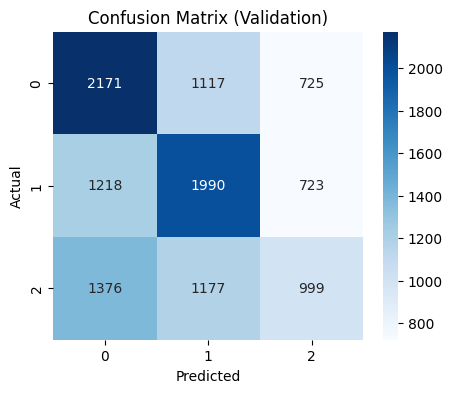

In [15]:
# stratify로 클래스 비율 유지
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled_df, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
print(y.value_counts(normalize=True))

lr = LogisticRegression(max_iter=10000, multi_class='multinomial', solver='lbfgs', random_state=42)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
gb = GradientBoostingClassifier(random_state=42)
lgb = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('gb', gb), ('lgb', lgb)],
    voting='soft'
)

# --- 5. 학습 ---
ensemble.fit(X_train, y_train)

# --- 6. 검증 ---
y_pred = ensemble.predict(X_val)
y_prob = ensemble.predict_proba(X_val)

acc = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_prob)
print(f"\n✅ Validation Accuracy: {acc:.4f}")
print(f"✅ Validation LogLoss: {loss:.4f}")

# 추가 리포트
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['A win', 'B win', 'Tie']))

# --- 7. 혼동 행렬 시각화 ---
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 8. 최종 예측 ---
# test_df_scaled 준비
X_test_scaled = X_scaled_df.loc[test_df.index] if len(test_df) == len(X_scaled_df) else X_scaled_df.iloc[:len(test_df)]
test_pred = ensemble.predict_proba(X_test_scaled)

In [ ]:
submission_df['winner_model_a'] = test_pred[:, 0]
submission_df['winner_model_b'] = test_pred[:, 1]
submission_df['winner_tie'] = test_pred[:, 2]
submission_df.to_csv('submission_final_ensemble.csv', index=False)


🎯 submission_final_ensemble.csv saved successfully!


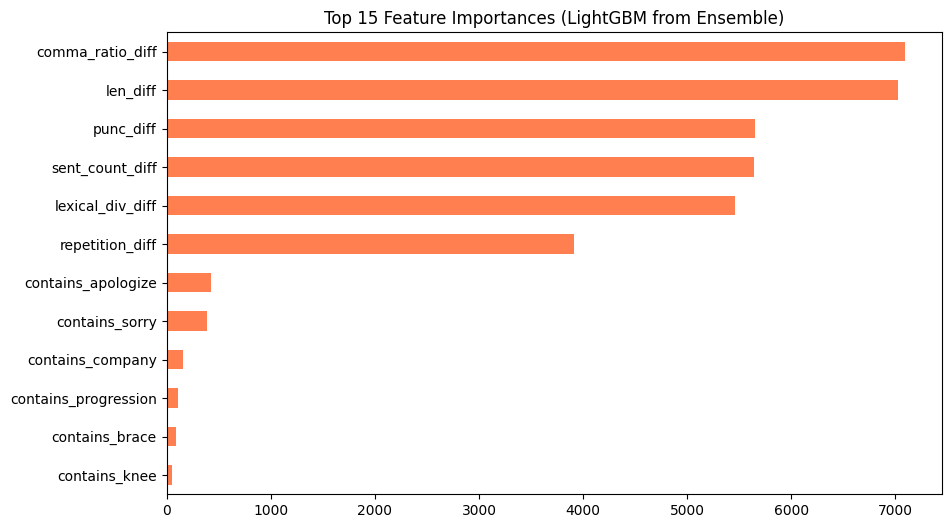

In [21]:
# VotingClassifier 내부 모델 리스트 확인
ensemble.estimators_

# LGBMClassifier 객체 가져오기
lgb_fitted = [est for est in ensemble.estimators_ if isinstance(est, LGBMClassifier)][0]

# 중요도 시각화
importances = pd.Series(lgb_fitted.feature_importances_, index=X_train.columns)
plt.figure(figsize=(10,6))
importances.nlargest(15).plot(kind='barh', color='coral')
plt.title("Top 15 Feature Importances (LightGBM from Ensemble)")
plt.gca().invert_yaxis()
plt.show()

## 피쳐 간 다중공선성 확인
하지만 여전히 len_diff나 comma_ratio_diff는 관련이 있어보인다
다중공선성을 원활히 제거하지 않으면 과적합 및 영향력 누적으로 인해 과도한 표현 가능성이 있으므로 제거한다.

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산용 DataFrame 준비
vif_df = pd.DataFrame()
vif_df["feature"] = X_scaled_df.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled_df.values, i)
                 for i in range(X_scaled_df.shape[1])]

vif_df = vif_df.sort_values("VIF", ascending=False).reset_index(drop=True)
print(vif_df)

                 feature       VIF
0       lexical_div_diff       inf
1        repetition_diff       inf
2               len_diff  3.219326
3        sent_count_diff  2.271157
4              punc_diff  1.964435
5         contains_brace  1.404719
6          contains_knee  1.404424
7     contains_apologize  1.028524
8         contains_sorry  1.028081
9       comma_ratio_diff  1.014690
10      contains_company  1.005574
11  contains_progression  1.000984


/Users/youjunglee/Proj2/proj2/.venv/lib/python3.14/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [25]:
vif_df = pd.DataFrame({
    "feature": X_scaled_df.columns,
    "VIF": [variance_inflation_factor(X_scaled_df.values, i)
            for i in range(X_scaled_df.shape[1])]
})

vif_df["status"] = pd.cut(
    vif_df["VIF"],
    bins=[0, 5, 10, float("inf")],
    labels=["Low", "Moderate", "High"]
)

vif_df = vif_df.sort_values("VIF", ascending=False).reset_index(drop=True)
print(vif_df)

                 feature       VIF status
0       lexical_div_diff       inf   High
1        repetition_diff       inf   High
2               len_diff  3.219326    Low
3        sent_count_diff  2.271157    Low
4              punc_diff  1.964435    Low
5         contains_brace  1.404719    Low
6          contains_knee  1.404424    Low
7     contains_apologize  1.028524    Low
8         contains_sorry  1.028081    Low
9       comma_ratio_diff  1.014690    Low
10      contains_company  1.005574    Low
11  contains_progression  1.000984    Low


/Users/youjunglee/Proj2/proj2/.venv/lib/python3.14/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


- The VIF inspection revealed perfect linear dependency between lexical_div_diff and repetition_diff (VIF = ∞).
- Both features measure lexical richness in inverse directions: as diversity increases, repetition decreases almost deterministically.
- To minimize redundancy, repetition_diff was excluded.

### Lexical 기반 피쳐 정리

In [26]:
selected_tab_features = [
    'len_diff', 'punc_diff', 'sent_count_diff', 'comma_ratio_diff',
    'lexical_div_diff',
    'contains_company', 'contains_brace', 'contains_knee',
    'contains_progression', 'contains_apologize', 'contains_sorry'
]
X_tab = X_scaled_df[selected_tab_features]

In [27]:
X_tab

,len_diff,punc_diff,sent_count_diff,comma_ratio_diff,lexical_div_diff,contains_company,contains_brace,contains_knee,contains_progression,contains_apologize,contains_sorry
0,3.952550,3.333333,3.000000,-0.509879,-0.550103,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.634638,-0.750000,-1.777778,-0.247947,-0.713681,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.084223,-1.250000,-0.666667,-0.727202,0.816672,0.0,0.0,0.0,0.0,0.0,0.0
3,1.921708,1.666667,1.222222,0.382777,-0.593601,0.0,0.0,0.0,0.0,0.0,0.0
4,0.626335,0.833333,0.222222,0.069289,-0.709755,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
57472,-0.190985,0.250000,1.000000,1.690206,1.050461,0.0,0.0,0.0,0.0,0.0,0.0
57473,-0.007117,0.000000,-1.222222,0.436278,0.239260,0.0,0.0,0.0,0.0,0.0,0.0
57474,8.451957,4.416667,10.111111,-0.402496,-0.398586,0.0,0.0,0.0,0.0,0.0,0.0
57475,-0.633452,-0.333333,-0.666667,0.232915,0.009375,0.0,0.0,0.0,0.0,0.0,0.0
